Imports and Configs

In [1]:
import os, re, hashlib, json, pandas as pd, requests
from urllib.parse import urlparse
from typing import TypedDict, List, Dict, Any
from datetime import datetime

from langgraph.graph import StateGraph, END
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document

# =========================
# CONFIG
# =========================
CSV_PATH    = os.environ.get("NEWS_CSV", "articles.csv")         # your CSV path
INDEX_DIR   = os.environ.get("INDEX_DIR", "faiss_news_index")
EMBED_MODEL = os.environ.get("EMBED_MODEL", "sentence-transformers/all-MiniLM-L6-v2")

# Ollama (Llama 3) local server
OLLAMA_URL   = os.environ.get("OLLAMA_URL", "http://localhost:11434/api/chat")
OLLAMA_MODEL = os.environ.get("OLLAMA_MODEL", "llama3:latest")

DATE_COL = "published_date"
AID_COL  = "id_article"  # your CSV id column
ALL_CATEGORIES = ["Technology","World","Politics","Science","Health","Sports","Culture","Entertainment","Society"]


Helper Functions

In [2]:
def pretty_date(date_str):
    if not date_str or str(date_str) in ("nan","NaT"): return "Unknown date"
    try:
        dt = datetime.fromisoformat(str(date_str).replace("Z","+00:00"))
        return dt.strftime("%Y-%m-%d %H:%M UTC")
    except Exception:
        return str(date_str)

def ollama_chat(prompt: str, max_tokens: int = 220, temperature: float = 0.3) -> str:
    payload = {
        "model": OLLAMA_MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "stream": False,
        "options": {"num_predict": max_tokens, "temperature": temperature}
    }
    r = requests.post(OLLAMA_URL, json=payload, timeout=300)
    r.raise_for_status()
    return r.json().get("message", {}).get("content", "").strip()

def _parse_json_from_text(txt: str) -> Dict[str, Any]:
    """
    Grab the last JSON-looking object from model output and parse it.
    """
    m = re.search(r"\{[\s\S]*\}$", txt.strip())
    if not m:
        m = re.search(r"\{[\s\S]*?\}", txt, re.DOTALL)
    if not m:
        return {"bias_decision": "Unclear", "decision_reasoning": "Model returned no JSON."}
    try:
        return json.loads(m.group())
    except Exception as e:
        return {"bias_decision": "Unclear", "decision_reasoning": f"JSON parse error: {e}"}


Retriever + Rag


In [6]:
def load_retriever():
    if not os.path.exists(CSV_PATH):
        raise FileNotFoundError(f"CSV not found at {CSV_PATH}. Set NEWS_CSV or put articles.csv beside the notebook.")
    df = pd.read_csv(CSV_PATH).fillna("")

    # ensure base columns
    for col in ["title","content","url","source",DATE_COL,"category",AID_COL]:
        if col not in df.columns:
            df[col] = ""

    # id normalize (fallback if blank)
    def _ensure_id(val, row):
        s = str(val).strip()
        if s and s.lower() not in ("nan","none","null"):
            return s
        base = f"{row.get('url','')}|{row.get(DATE_COL,'')}|{row.get('title','')}"
        return hashlib.md5(base.encode("utf-8")).hexdigest()
    df[AID_COL] = df.apply(lambda r: _ensure_id(r.get(AID_COL, ""), r), axis=1)

    # source normalize
    def _canon(row):
        s = (row.get("source") or "").strip()
        if s: return s
        url = (row.get("url") or "").strip()
        try:
            host = urlparse(url).netloc.lower()
            return host[4:] if host.startswith("www.") else (host or "unknown")
        except:
            return "unknown"
    df["source_norm"] = df.apply(_canon, axis=1)

    # fast lookups
    article_by_id = {
        str(row[AID_COL]): {
            "id": str(row[AID_COL]),
            "title": str(row["title"]).strip(),
            "content": str(row["content"]).strip(),
            "url": str(row["url"]).strip(),
            "source": str(row["source"]).strip(),
            "source_norm": str(row["source_norm"]).strip(),
            "published_date": str(row[DATE_COL]).strip(),
            "category": str(row.get("category","")).strip(),
        }
        for _, row in df.iterrows()
    }
    article_by_url = {
        str(row["url"]).strip(): article_by_id[str(row[AID_COL])]
        for _, row in df.iterrows() if str(row.get("url","")).strip()
    }

    # FAISS docs (include id)
    docs = []
    for _, row in df.iterrows():
        meta = {k: str(row[k]) for k in df.columns if k != "content"}
        meta["id"] = str(row[AID_COL])
        docs.append(Document(page_content=f"{row['title']}\n\n{row['content']}", metadata=meta))

    emb = HuggingFaceEmbeddings(model_name=EMBED_MODEL)
    os.makedirs(INDEX_DIR, exist_ok=True)
    if os.path.exists(os.path.join(INDEX_DIR, "index.faiss")):
        vs = FAISS.load_local(INDEX_DIR, emb, allow_dangerous_deserialization=True)
    else:
        vs = FAISS.from_documents(docs, emb)
        vs.save_local(INDEX_DIR)

    return vs.as_retriever(search_kwargs={"k": 12}), article_by_id, article_by_url

retriever, ARTICLE_BY_ID, ARTICLE_BY_URL = load_retriever()
len(ARTICLE_BY_ID), list(ARTICLE_BY_ID)[:3]


C:\Users\HP\AppData\Local\Temp\ipykernel_1816\2546311189.py:58: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  emb = HuggingFaceEmbeddings(model_name=EMBED_MODEL)


(4197, ['52633a4d3202', 'c7ef2347bbf7', 'ea303e4d353c'])

Bias Analysis

In [ ]:
class BiasState(TypedDict):
    article: str
    bias_json: Dict[str, Any] | None
    decision_json: Dict[str, Any] | None
    
def node_bias_analyze_main(state: dict) -> dict:
    out = node_bias_analyze({
        "article": state.get("article", ""),
        "bias_json": state.get("bias_json"),
        "decision_json": state.get("decision_json"),
    })
    state.update(out)
    return state

def node_bias_decide_main(state: dict) -> dict:
    out = node_bias_decide({
        "article": state.get("article", ""),
        "bias_json": state.get("bias_json"),
        "decision_json": state.get("decision_json"),
    })
    state.update(out)
    return state
def node_bias_analyze(state: BiasState) -> BiasState:
    article = (state.get("article") or "").strip()
    if not article:
        return {"article": article, "bias_json": {"error": "empty article text"}, "decision_json": None}

    prompt = f"""
You are a media-analysis expert.
Analyze the news article below and output ONLY valid JSON with these fields:

- credibility_score: integer 0–100
- political_bias: one of "Left", "Right", "Center", "Unknown"
- emotional_tone: one of "Neutral", "Emotional", "Manipulative"
- persuasive_techniques: short list of strings
- bias_summary: 1–2 sentence summary
- analysis_reasoning: 1–2 sentences

Article:
\"\"\"{article[:8000]}\"\"\"\n
Return ONLY JSON like this:
{{
  "credibility_score": 0,
  "political_bias": "Center",
  "emotional_tone": "Neutral",
  "persuasive_techniques": ["framing", "appeal to authority"],
  "bias_summary": "...",
  "analysis_reasoning": "..."
}}
"""
    out = ollama_chat(prompt, max_tokens=380, temperature=0.2)
    return {"article": article, "bias_json": _parse_json_from_text(out), "decision_json": None}

def node_bias_decide(state: BiasState) -> BiasState:
    bias = state.get("bias_json") or {}
    prompt = f"""
You will receive a JSON analysis of a news article.

Decide whether the article is "Biased" or "Not Biased".

Heuristics:
- "Biased" if political_bias != "Center"/"Unknown", OR emotional_tone == "Manipulative", OR credibility_score < 50.
- Otherwise "Not Biased".

Return ONLY JSON:
{{
  "bias_decision": "Biased" or "Not Biased",
  "decision_reasoning": "brief justification"
}}

Input:
{json.dumps(bias, indent=2)}
"""
    out = ollama_chat(prompt, max_tokens=220, temperature=0.2)
    return {"article": state.get("article",""), "bias_json": bias, "decision_json": _parse_json_from_text(out)}




Source Check

In [5]:
def _load_source_reliability():
    candidate_paths = [
        "data/source_reliability_scores.csv",
        "configs/source_reliability_scores.csv",
        "source_reliability_scores.csv",
        "/mnt/data/source_reliability_scores.csv",
    ]
    for p in candidate_paths:
        if os.path.exists(p):
            df = pd.read_csv(p)
            break
    else:
        df = pd.DataFrame(columns=["domain", "score", "label"])

    def _norm(s: str) -> str:
        s = (s or "").lower().strip()
        s = s.replace("the ", " ")
        s = re.sub(r"[^a-z0-9 ]+", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

    if "domain" in df.columns:
        df["norm"] = df["domain"].astype(str).map(_norm)
    else:
        df["norm"] = ""
    return df, _norm

SOURCE_DF, _NORM_SOURCE = _load_source_reliability()

def _source_name_from_item(item: Dict[str, Any]) -> str:
    name = item.get("source") or item.get("source_norm")
    if name:
        return str(name)
    url = item.get("url", "")
    if url:
        host = urlparse(url).hostname or ""
        if host:
            parts = host.split(".")
            core = parts[-2] if len(parts) >= 2 else host
            return core
    return "(unknown)"

def lookup_source_reliability(item: Dict[str, Any]) -> Dict[str, Any]:
    name = _source_name_from_item(item)
    n = _NORM_SOURCE(name)
    df = SOURCE_DF

    if not df.empty:
        cand = df[df["norm"].apply(lambda x: x in n or n in x)]
        if len(cand) == 0:
            ntoks = set(n.split())
            cand = df[df["norm"].apply(lambda x: len(ntoks & set(x.split())) >= 1)]

        if len(cand) > 0:
            row = cand.iloc[0]
            label = str(row.get("label", "Unknown"))
            score = row.get("score", None)

            label_clean = str(label).strip().title()
            if label_clean == "Reliable":
                decision = "Reliable"
            elif label_clean in ("Mostly Reliable", "Mostly-Reliable"):
                decision = "Mostly Reliable"
            elif label_clean == "Mixed":
                decision = "Mixed"
            else:
                try:
                    if float(score) < 0.5:
                        decision = "Not Reliable"
                    elif float(score) < 0.7:
                        decision = "Mostly Reliable"
                    else:
                        decision = "Reliable"
                except Exception:
                    decision = label_clean or "Mixed"

            return {
                "source_name": name,
                "source_reliability": decision,
                "source_label": label,
                "source_score": (float(score) if pd.notna(score) else None),
            }

    return {
        "source_name": name,
        "source_reliability": "Mixed",
        "source_label": "Unknown",
        "source_score": None,
    }


Summary

In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline as hf_pipeline
import torch

def load_flan():
    model_name = "google/flan-t5-base"
    device = 0 if torch.cuda.is_available() else -1
    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    return hf_pipeline("text2text-generation", model=mdl, tokenizer=tok, device=device)

flan = load_flan()

def _sum_chunk(text: str, max_new_tokens: int = 180) -> str:
    prompt = (
        "Summarize the following news article in 3–5 concise bullet points, factual and neutral:\n\n"
        f"{text}"
    )
    out = flan(prompt, max_new_tokens=max_new_tokens, temperature=0.0, do_sample=False)
    return out[0]["generated_text"].strip()

def summarize_text_long(text: str) -> str:
    if not text: return ""
    CHUNK = 1800  # chars
    chunks = [text[i:i+CHUNK] for i in range(0, len(text), CHUNK)]
    parts = [_sum_chunk(c, 160) for c in chunks]
    if len(parts) == 1:
        return parts[0]
    combined = "\n\n".join(parts)
    final = flan(
        "Combine these bullet-point summaries into 5–7 bullets, removing redundancy and keeping key facts:\n\n"
        + combined,
        max_new_tokens=200,
        temperature=0.0,
        do_sample=False
    )[0]["generated_text"].strip()
    return final


c:\Users\HP\Documents\dl_project\News-Agent - Copy\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [8]:
def get_article_text_by_id(aid: str) -> str:
    if aid and aid in ARTICLE_BY_ID:
        return ARTICLE_BY_ID[aid].get("content","") or ""
    return ""

def summarize_by_id(aid: str, title: str) -> str:
    content = get_article_text_by_id(aid)
    if not content:
        return "_No full text available in dataset to summarize._"
    try:
        summary = summarize_text_long(content)
        return f"**{title or '(Untitled)'}**\n\n{summary}"
    except Exception as e:
        return f"_Summary failed: {e}_"


Graph-Agent

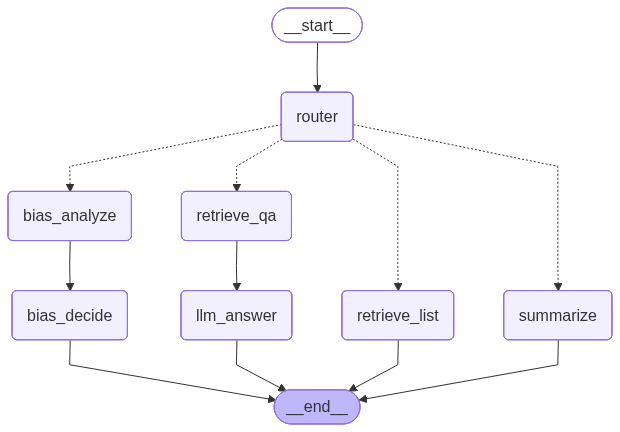

In [ ]:
class State(TypedDict):
    # core
    query: str
    k: int
    mode: str
    results: List[Dict[str, Any]] | List[Document]
    answer: str
    # actions
    action: str            # "", "summarize", "factcheck"
    aid: str               # article id for summarize
    article: str           # article text for factcheck path
    bias_json: Dict[str, Any] | None
    decision_json: Dict[str, Any] | None
    summary: str

def format_hits(hits: List[Document], k: int) -> List[Dict[str, Any]]:
    out, seen = [], set()
    for d in hits:
        meta = d.metadata or {}
        url = meta.get("url", "")
        domain = urlparse(url).netloc
        if domain in seen:
            continue
        seen.add(domain)
        out.append({
            "id": meta.get("id", ""),
            "title": meta.get("title", ""),
            "source": meta.get("source", "") or meta.get("source_norm", ""),
            "published_date": meta.get("published_date", ""),
            "url": url
        })
        if len(out) >= k: break
    return out

def _retrieve(query: str):
    try:
        return retriever.get_relevant_documents(query)
    except AttributeError:
        return retriever.invoke(query)

def route(state: State) -> str:
    # UI-triggered actions first
    act = (state.get("action") or "").lower().strip()
    if act == "factcheck":
        return "bias_analyze"
    if act == "summarize":
        return "summarize"

    # default question vs. category routing
    q = (state.get("query") or "").lower().strip()
    if q.endswith("?") or re.match(r"^(what|who|why|how|when|where)\b", q):
        state["mode"] = "qa"
        return "retrieve_qa"
    state["mode"] = "list"
    return "retrieve_list"

def router_node(state: State) -> State:
    route(state); return state

def node_retrieve_list(state: State) -> State:
    docs = _retrieve(state["query"])
    state["results"] = format_hits(docs, state["k"])
    return state

def node_retrieve_qa(state: State) -> State:
    docs = _retrieve(state["query"])
    state["results"] = docs[:6]
    return state

def node_llm_answer(state: State) -> State:
    docs: List[Document] = state["results"]
    if not docs:
        state["answer"] = "I couldn't find relevant articles to answer that."
        return state
    max_docs, max_chars = 4, 350
    context = []
    for d in docs[:max_docs]:
        m = d.metadata or {}
        title = m.get("title","")
        snippet = d.page_content[:max_chars]
        context.append(f"[{title}] {snippet}")
    ctx = "\n\n".join(context)

    prompt = (
        "You are a concise journalist assistant.\n"
        "Use ONLY the CONTEXT to answer the user's question. "
        "Cite article titles in parentheses when relevant.\n\n"
        f"CONTEXT:\n{ctx}\n\n"
        f"QUESTION: {state['query']}\n\n"
        "ANSWER:"
    )
    state["answer"] = ollama_chat(prompt, max_tokens=220, temperature=0.3)
    return state

def node_summarize(state: State) -> State:
    aid = (state.get("aid") or "").strip()
    title = ARTICLE_BY_ID.get(aid, {}).get("title", "")
    state["summary"] = summarize_by_id(aid, title)
    return state

# wrappers for the main graph


# Build graph
g = StateGraph(State)
g.add_node("router", router_node)
g.set_entry_point("router")

# retrieval branches
g.add_node("retrieve_list", node_retrieve_list)
g.add_node("retrieve_qa", node_retrieve_qa)
g.add_node("llm_answer", node_llm_answer)

# bias path inside main graph
g.add_node("bias_analyze", node_bias_analyze_main)
g.add_node("bias_decide", node_bias_decide_main)

# action branch
g.add_node("summarize", node_summarize)
g.add_edge("summarize", END)

# routing
g.add_conditional_edges("router", route, {
    "retrieve_list": "retrieve_list",
    "retrieve_qa": "retrieve_qa",
    "bias_analyze": "bias_analyze",
    "summarize": "summarize",
})

# terminal edges
g.add_edge("retrieve_list", END)
g.add_edge("retrieve_qa", "llm_answer")
g.add_edge("llm_answer", END)

# bias edges
g.add_edge("bias_analyze", "bias_decide")
g.add_edge("bias_decide", END)

graph = g.compile()
graph


Architecture des modeles: 

Embeddings model Architecture : MiniLM-L6


<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
C:\Users\HP\AppData\Local\Temp\ipykernel_4952\619203814.py:1: SyntaxWarning: invalid escape sequence '\e'
  display(Image(filename="Architectures\encoder.jpg"))


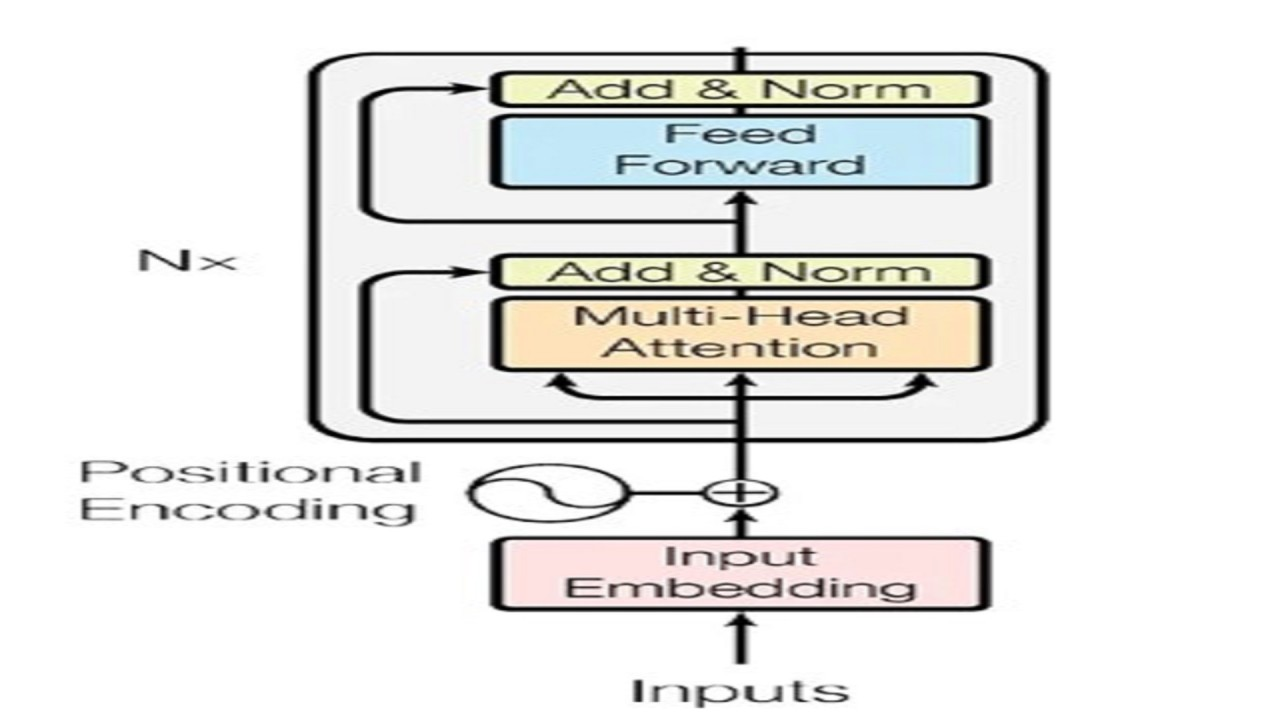

In [8]:
display(Image(filename="Architectures\encoder.jpg"))

Architecture llama 3:

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
C:\Users\HP\AppData\Local\Temp\ipykernel_4952\675311455.py:4: SyntaxWarning: invalid escape sequence '\l'
  display(Image(filename="Architectures\llama architecture.png"))


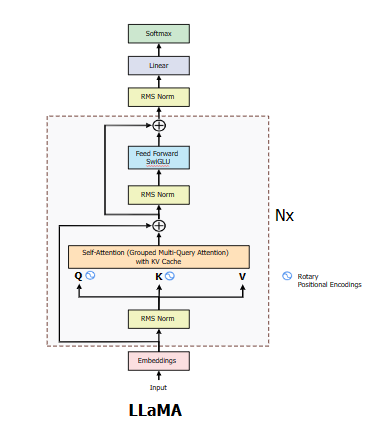

In [2]:
from IPython.display import Image, display

# Option 1: Local image
display(Image(filename="Architectures\llama architecture.png"))




RAG

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\HP\AppData\Local\Temp\ipykernel_1816\3034426942.py:1: SyntaxWarning: invalid escape sequence '\R'
  display(Image(filename="Architectures\Rag process.png"))


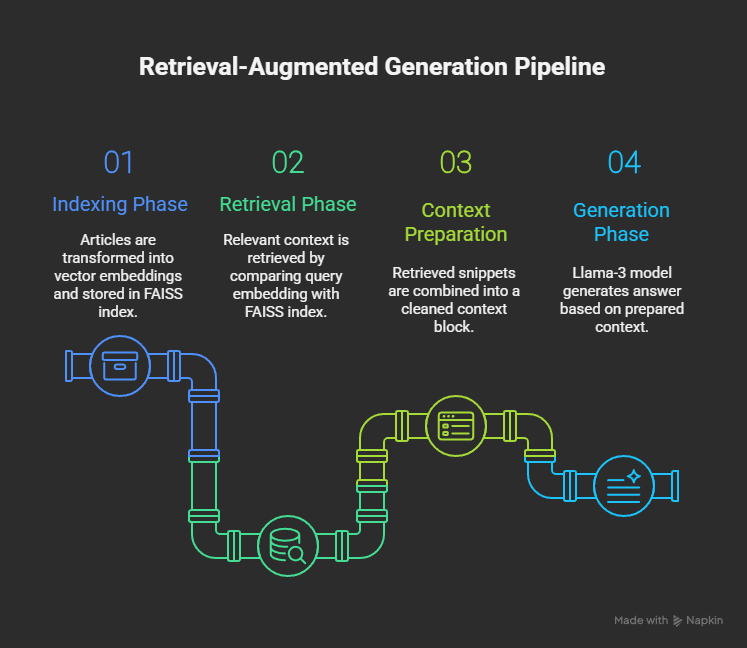

In [18]:
display(Image(filename="Architectures\Rag process.png"))

Architecture Flan T5 for summary


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\HP\AppData\Local\Temp\ipykernel_4952\3368491273.py:1: SyntaxWarning: invalid escape sequence '\F'
  display(Image(filename="Architectures\FLAN T5.jpeg"))


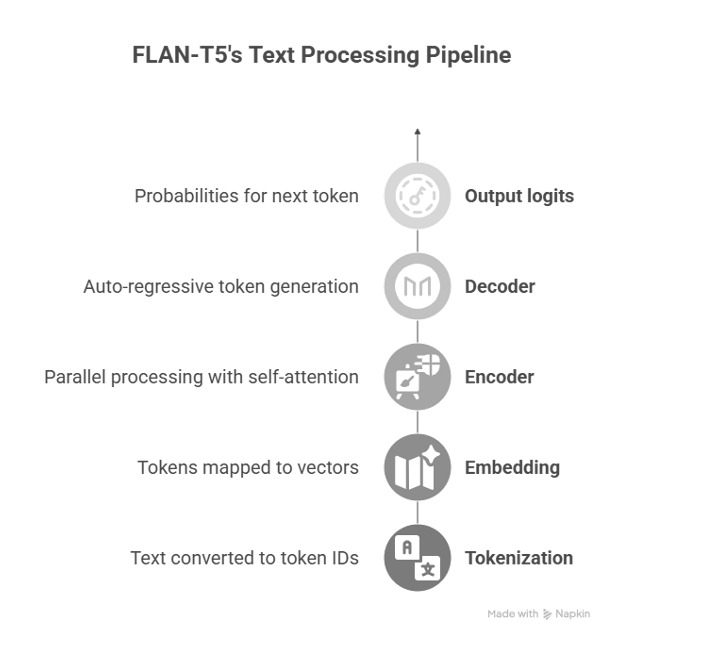

In [7]:
display(Image(filename="Architectures\FLAN T5.jpeg"))

Source Scoring Model Architecture

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\HP\AppData\Local\Temp\ipykernel_4952\4064935483.py:1: SyntaxWarning: invalid escape sequence '\S'
  display(Image(filename="Architectures\Scoring_source.jpeg"))


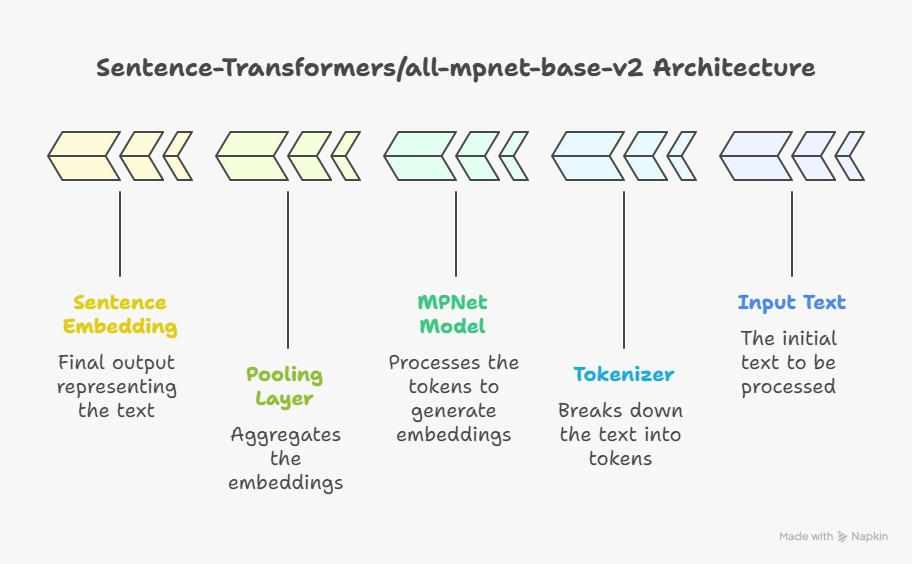

In [5]:
display(Image(filename="Architectures\Scoring_source.jpeg"))